In this notebook, I will be going through the implementation of RFM or Recency, Frequency and Monetary. This was popularised in the 1960s and 1970s. It might be old but the Wharton's course on Customer Analytics at Coursera teaches this pretty well, so if you feel like checking it out here's the [link](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=video&cd=&cad=rja&uact=8&ved=2ahUKEwjj4ZeB3bvrAhU16nMBHRuRCJ8QtwIwAXoECAEQAQ&url=https%3A%2F%2Fwww.coursera.org%2Flecture%2Fwharton-customer-analytics%2Fbeyond-period-2-7fduC&usg=AOvVaw3-I-Zc9QAF2OrUWPaAAZGW).

# Importing and Reading Data:

Importing pandas for working with the data:

In [1]:
import pandas as pd

In [2]:
# Reading the data:
data = pd.read_csv("Retail_Data_Transactions.csv")

In [3]:
data.head()

customer_id trans_date  tran_amount
0      CS5295  11-Feb-13           35
1      CS4768  15-Mar-15           39
2      CS2122  26-Feb-13           52
3      CS1217  16-Nov-11           99
4      CS1850  20-Nov-13           78

# Playing with the Data:

In [4]:
# Defining Recency as two of the three columns in data:
recency = data[['trans_date', 'customer_id']]

Checking the data for the number of unique values:

In [5]:
recency.apply(pd.Series.nunique)

trans_date     1401
customer_id    6889
dtype: int64

Lets take a look at the dimensions of our data:

In [6]:
recency.shape

(125000, 2)

Well, since there are more examples than the number of unique customer ids this means that a lot of customers bought from us more than once,

Time to work with dates:

In [7]:
import time

recency['trans_date'] = pd.to_datetime(recency.trans_date)

C:\Users\priagungkhu\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
# now refers to the latest date available in the data, to which we will peg our rececny dimensions on:
now = max(recency['trans_date'])

The groupby function in pandas allows of for grouping of many index column values or as we saw above there were more than one instances of a single customer purchasing so why not combine all their purchases?

In [9]:
recency = recency.groupby(['customer_id']).max()

Okay so, recency refers to the time since the last purchase. So lets find out the number of days:

In [10]:
recency_days = now - recency['trans_date']

In [11]:
recency_days = pd.DataFrame(recency_days)
recency_days.head()

trans_date
customer_id           
CS1112         61 days
CS1113         35 days
CS1114         32 days
CS1115         11 days
CS1116        203 days

Monetary refers to the total money spent by a customer overtime:

In [12]:
monetary = data[['customer_id', 'tran_amount']]

Via Groupby here, I sum up all the transactions of every respective customer:

In [13]:
monetary = monetary.groupby(['customer_id']).sum()

In [14]:
monetary.head()

tran_amount
customer_id             
CS1112              1012
CS1113              1490
CS1114              1432
CS1115              1659
CS1116               857

Frequency refers to the number of times a customer has made purchases:

In [25]:
frequency = data[['customer_id', 'trans_date']]

Via Groupby, I use count to count the number of times the customer has made purchases:

In [26]:
frequency = frequency.groupby(['customer_id']).count()

In [27]:
frequency.head()

trans_date
customer_id            
CS1112               15
CS1113               20
CS1114               19
CS1115               22
CS1116               13

Finally concatenating the dataframes:

In [28]:
recency = pd.DataFrame(recency_days['trans_date'].astype('timedelta64[D]'))
recency.columns = ['recency']

Taking a look at this beauty:

In [29]:
recency.head()


recency
customer_id         
CS1112          61.0
CS1113          35.0
CS1114          32.0
CS1115          11.0
CS1116         203.0

Since we have the absolute integer values of all the three key elements lets concatenate them:

In [41]:
rfm = pd.concat([recency, frequency, monetary], axis=1)

In [42]:
# Defining the columns:
rfm.columns=['recency', 'frequency', 'monetary']

rfm.head()

recency  frequency  monetary
customer_id                              
CS1112          61.0         15      1012
CS1113          35.0         20      1490
CS1114          32.0         19      1432
CS1115          11.0         22      1659
CS1116         203.0         13       857

# RFM Analysis:

I think we should take a look at the distribution because plotting can give a really good idea of what is up with the customers:

Text(0.5, 0, 'Days since last purchase')

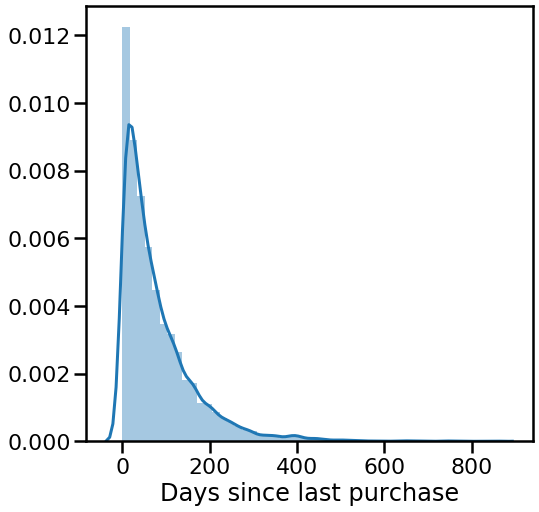

In [43]:
# Plotting for the last day since the customer made a purchase:

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
sns.set_context("poster")
sns.distplot(rfm['recency'])
plt.xlabel('Days since last purchase')

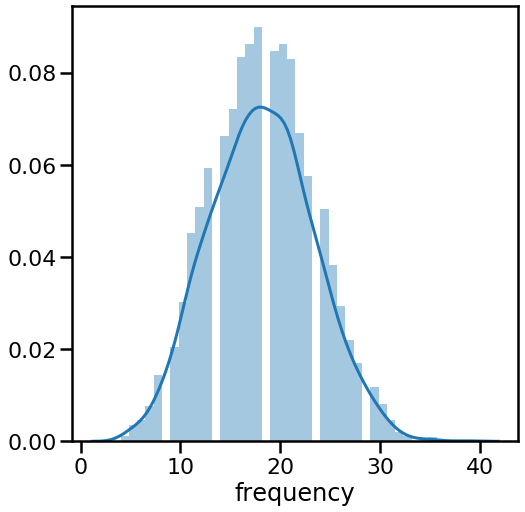

In [44]:
# Plotting the number of times the customer has made a purchase:

plt.figure(figsize=(8,8))
sns.set_context("poster")
sns.distplot(rfm['frequency'])


Text(0.5, 0, 'Dollars')

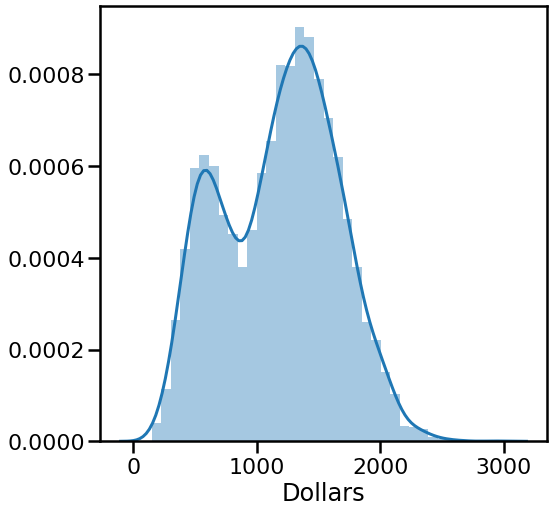

In [45]:
# Plotting the total revenue that the particular customer brought in to the shop:

plt.figure(figsize=(8,8))
sns.set_context("poster")
sns.distplot(rfm['monetary'])
plt.xlabel('Dollars')

Since we have a basic idea of what the distribution of the three indicators, lets use quantiles to educate ourselves further with quantiles:

In [46]:
rfm.quantile([.33, .66, 1], axis=0)

recency  frequency  monetary
0.33     30.0       16.0     973.0
0.66     85.0       20.0    1414.0
1.00    857.0       39.0    2933.0

In [47]:
# copying the rfm dataset so that it isn't affected by the changes:

RFMscores = rfm.copy()

# RFM SCORE CARD:

Below is the conversion of columns into RFM scores between 1 to 4. These will come handy in calculating the aggregate RFM Score. As per the quantile I have assigned the indices in the columns a value between 1 to 4. 

> '4' being great and '1' being poor.


Apart from that what must be noted is that different columns see this score differently. Such as, the higher the monetary value the higher chance of that value being 4 since more revenue is never a bad thing. While, smaller the value of Recency the more likely it is that the index will be given the value of 1, since the more recent customer is more likely to comeback. In case of Frequency the metrics are the same as Monetary since, higher the Frequency the more beneficial it is for business.

In [48]:
# Converting Recency:
RFMscores['recency'] = [3 if x < 30 else x for x in RFMscores['recency']]
RFMscores['recency'] = [2 if 85 >= x >= 30  else x for x in RFMscores['recency']]
RFMscores['recency'] = [1 if x > 85 else x for x in RFMscores['recency']]

In [49]:
# Converting Frequency:
RFMscores['frequency'] = [1 if a < 16 else a for a in RFMscores['frequency']]
RFMscores['frequency'] = [2 if 20 >= a >= 16 else a for a in RFMscores['frequency']]
RFMscores['frequency'] = [3 if a > 20 else a for a in RFMscores['frequency']]

In [50]:
# Converting Monetary:

RFMscores['monetary'] = [1 if x < 973 else x for x in RFMscores['monetary']]
RFMscores['monetary'] = [2 if 1414 >= x >= 973 else x for x in RFMscores['monetary']]
RFMscores['monetary'] = [3 if x > 1414 else x for x in RFMscores['monetary']]

Lets check if we got it right by taking a look at the number of unique values in each column:

In [51]:
RFMscores.apply(pd.Series.nunique)

recency      3
frequency    3
monetary     3
dtype: int64

In [52]:
RFMscores.head()

recency  frequency  monetary
customer_id                              
CS1112           2.0          1         2
CS1113           2.0          2         3
CS1114           2.0          2         3
CS1115           3.0          3         3
CS1116           1.0          1         1

# Aggregate RFM Score:

The aggregate RFM Score is basically the average of the RFM values in the RFM Scores dataset:

In [53]:
score = pd.DataFrame((RFMscores['recency'] + RFMscores['frequency'] + RFMscores['monetary'])/3, columns=['AggrScore'])


In [54]:
# Concatenating the two:
RFMscores = pd.concat([RFMscores, score], axis = 1)

In [55]:
RFMscores.head()

recency  frequency  monetary  AggrScore
customer_id                                         
CS1112           2.0          1         2   1.666667
CS1113           2.0          2         3   2.333333
CS1114           2.0          2         3   2.333333
CS1115           3.0          3         3   3.000000
CS1116           1.0          1         1   1.000000

# Most Valuable Customers (MVCs):

In [56]:
# Using Quantiles we find the limit for our top 25% customers:
RFMscores.quantile([.66, 1], axis=0)

recency  frequency  monetary  AggrScore
0.66      2.0        2.0       2.0   2.333333
1.00      3.0        3.0       3.0   3.000000

In [57]:
topcustomers = RFMscores['AggrScore'].iloc[[x >= 2.333333 for x in RFMscores['AggrScore']]]

In [58]:
MVCs = pd.DataFrame(topcustomers, columns = ['AggrScore'])

In [59]:
MostValuableCustomers = list(MVCs.index)

In [60]:
MostValuableCustomers

['CS1113',
 'CS1114',
 'CS1115',
 'CS1120',
 'CS1121',
 'CS1127',
 'CS1128',
 'CS1130',
 'CS1132',
 'CS1133',
 'CS1136',
 'CS1138',
 'CS1140',
 'CS1141',
 'CS1142',
 'CS1145',
 'CS1146',
 'CS1148',
 'CS1149',
 'CS1151',
 'CS1152',
 'CS1154',
 'CS1156',
 'CS1157',
 'CS1159',
 'CS1161',
 'CS1162',
 'CS1164',
 'CS1170',
 'CS1171',
 'CS1173',
 'CS1174',
 'CS1176',
 'CS1178',
 'CS1179',
 'CS1180',
 'CS1181',
 'CS1182',
 'CS1183',
 'CS1184',
 'CS1185',
 'CS1186',
 'CS1187',
 'CS1188',
 'CS1189',
 'CS1191',
 'CS1194',
 'CS1195',
 'CS1196',
 'CS1198',
 'CS1200',
 'CS1203',
 'CS1205',
 'CS1206',
 'CS1209',
 'CS1210',
 'CS1214',
 'CS1215',
 'CS1216',
 'CS1217',
 'CS1218',
 'CS1219',
 'CS1222',
 'CS1227',
 'CS1229',
 'CS1230',
 'CS1231',
 'CS1234',
 'CS1235',
 'CS1236',
 'CS1237',
 'CS1238',
 'CS1240',
 'CS1241',
 'CS1244',
 'CS1247',
 'CS1248',
 'CS1249',
 'CS1250',
 'CS1254',
 'CS1255',
 'CS1258',
 'CS1259',
 'CS1260',
 'CS1261',
 'CS1267',
 'CS1268',
 'CS1270',
 'CS1271',
 'CS1272',
 'CS1273',

And thus, we have the names of the customers who love the shop! If you liked the notebook, an upvote would be much appreciated. :-)